In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals


import tensorflow as tf
tf.enable_eager_execution()
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
from tensorflow.keras.layers import *
import time
import cv2
from IPython import display
from tqdm import tqdm
TRAIN_DIR='./train'
IMG_size = 56
%matplotlib inline
from IPython.display import clear_output


def create_train_data():
    training_data = []
    training_labels = []
    count=0
    for img in tqdm(os.listdir(TRAIN_DIR)):
        label = [5]
        path = os.path.join(TRAIN_DIR,img)
        try:
            img = cv2.imread(path)
            img = cv2.resize(img,(IMG_size,IMG_size))
        except:
            continue
        training_data.append(np.array(img))
        training_labels.append(np.array(label))
        count+=1
        if count %300 ==0 and count>0:
            clear_output()
        if count >= 30000:
            break
    return training_data,training_labels
                             
train_images,train_labels=create_train_data()
train_labels = np.array(train_labels)
train_images = np.array(train_images)
train_images=train_images.reshape(train_images.shape[0],IMG_size, IMG_size, 3).astype('float32')
train_images = (train_images)/255



BUFFER_SIZE = 60000
BATCH_SIZE = 256
# Batch and shuffle the data

#train_images = np.load('train_images_paintings.npy')
#train_labels = np.load('train_labels_paintings.npy')
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
clear_output()
print('done')



done


 38%|███▊      | 30004/79433 [10:10<17:34, 46.86it/s]

In [2]:
np.save('train_images_paintings_30.npy',train_images)
np.save('train_labels_paintings_30.npy',train_labels)
print(train_images.shape)

(30000, 56, 56, 3)


In [7]:
def make_generator_model():
    model = tf.keras.Sequential([
        Dense(7*7*512*3, use_bias=False, input_shape=(100,)),
        BatchNormalization(),
        LeakyReLU(),
        Reshape((7, 7, 1536)),

        
        Conv2DTranspose(768, (5,5), strides=(1,1), padding='same', use_bias=False),
        BatchNormalization(),
        LeakyReLU(),
        
        Conv2DTranspose(384, (5,5), strides=(2,2), padding='same', use_bias=False),
        BatchNormalization(),
        LeakyReLU(),
        
        Conv2DTranspose(192, (5,5), strides=(2,2), padding='same', use_bias=False),
        BatchNormalization(),
        LeakyReLU(),
        
        Conv2DTranspose(3, (5,5), strides=(2,2), padding='same', use_bias=False),

    ])
    assert model.output_shape == (None, 56, 56, 3)
    return model

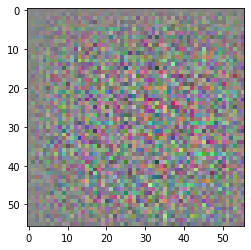

In [8]:
generator = make_generator_model()
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
arr = tf.keras.backend.eval(generated_image[0,:,:,:])
arr-=arr.min()
arr=arr/arr.max()
plt.imshow(arr)

In [9]:
def make_discriminator_model():
    model=tf.keras.Sequential([
        
        Conv2D(192, (5, 5), strides=(2, 2), padding='same',input_shape=[56, 56, 3]),
        LeakyReLU(),
        Dropout(0.3),
        
        Conv2D(384, (5, 5), strides=(2, 2), padding='same'),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        
        Flatten(),
        Dense(1)
        
    ])
    return model

In [10]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print(tf.keras.backend.eval(decision))

[[0.00047815]]


In [11]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    print("Calc D Loss")
    return total_loss
def generator_loss(fake_output):
    print("Calc G Loss")
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)


checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [12]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 10

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [18]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)
    print("STEP")
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    print("Gradients Dun")
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    print("Optimized")

In [19]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [20]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)
    # Produce images for the GIF as we go
    print("loop complete")
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [21]:
tf.executing_eagerly()

True

In [ ]:
train(train_dataset, EPOCHS)


Calc G Loss
Calc D Loss
STEP
Gradients Dun
Optimized
